In [ ]:
from google.colab import files
import zipfile, os

# Upload dataset ZIP (fec.2.zip)
uploaded = files.upload()   # choose fec.2.zip

# Extract files
zip_path = "fec.2.zip"
extract_path = "fce_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Inspect contents
for root, dirs, files in os.walk(extract_path):
    print(root, len(files))


Saving fec.2.zip to fec.2 (2).zip
fce_dataset 0
fce_dataset/fce 3
fce_dataset/fce/m2 3
fce_dataset/fce/json 3


In [ ]:
import os

print("Listing all files in dataset:\n")
for root, dirs, files in os.walk("fce_dataset"):
    for file in files:
        print(os.path.join(root, file))


Listing all files in dataset:

fce_dataset/fce/licence.txt
fce_dataset/fce/json_to_m2.py
fce_dataset/fce/readme.txt
fce_dataset/fce/m2/fce.train.gold.bea19.m2
fce_dataset/fce/m2/fce.dev.gold.bea19.m2
fce_dataset/fce/m2/fce.test.gold.bea19.m2
fce_dataset/fce/json/fce.train.json
fce_dataset/fce/json/fce.test.json
fce_dataset/fce/json/fce.dev.json


In [ ]:
import pandas as pd

# Load JSONL files correctly
train_df = pd.read_json("fce_dataset/fce/json/fce.train.json", lines=True)
dev_df   = pd.read_json("fce_dataset/fce/json/fce.dev.json", lines=True)
test_df  = pd.read_json("fce_dataset/fce/json/fce.test.json", lines=True)

# Combine into one DataFrame
df = pd.concat([train_df, dev_df, test_df], ignore_index=True)

# Inspect structure
print(df.head())
print(df.columns)


                                                text    age  q  script-s  \
0  Dear Sir or Madam,\n\nI am writing in order to...  21-25  1        31   
1  Unfortunately, Pat wasn't very good at keeping...  21-25  2        31   
2  10 June 2000\n\nDear Manager,\n\nI would like ...  26-30  1        29   
3  Fashion of the future\n\nPeople will wear this...  26-30  3        29   
4  DECEMBER 12TH\n\nPRINCIPAL MR. ROBERTSON\n\nDE...  16-20  1        28   

                                               edits  l1                id  \
0  [[0, [[71, 76, 'with', 'RT'], [118, 122, 'saw'...  ca  TR1*0102*2000*01   
1  [[0, [[233, 233, ',', 'MP'], [249, 249, '"', '...  ca  TR1*0102*2000*01   
2  [[0, [[238, 238, 'in', 'MT'], [473, 473, 'the'...  ko  TR2*0102*2000*01   
3  [[0, [[71, 76, '', 'UJ'], [91, 91, 'the', 'MD'...  ko  TR2*0102*2000*01   
4  [[0, [[61, 65, 'THANK', 'S'], [142, 144, 'ON',...  ca  TR3*0100*2000*02   

  answer-s  
0      4.3  
1      5.1  
2      3.3  
3      3.3  
4      2.

In [ ]:
# Ensure answer-s is numeric
df['answer-s'] = pd.to_numeric(df['answer-s'], errors='coerce')

# Map score → CEFR level
def score_to_level(score):
    if score < 2.5: return "A1"
    elif score < 3.5: return "A2"
    elif score < 4.5: return "B1"
    elif score < 5.5: return "B2"
    elif score < 6.5: return "C1"
    else: return "C2"

df['level'] = df['answer-s'].apply(score_to_level)


In [ ]:
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Clean text ---
def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', '', str(text))  # keep only letters
    return text.lower()

df['clean_text'] = df['text'].apply(clean_text)

# --- Encode CEFR levels ---
encoder = LabelEncoder()
df['level_encoded'] = encoder.fit_transform(df['level'])

# --- Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['level_encoded'], test_size=0.2, random_state=42
)

# --- Tokenization ---
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# --- Padding ---
X_train_pad = pad_sequences(X_train_seq, maxlen=200, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=200, padding='post', truncating='post')

print("Train shape:", X_train_pad.shape, "Test shape:", X_test_pad.shape)
print("Classes:", encoder.classes_)


Train shape: (1975, 200) Test shape: (494, 200)
Classes: ['A1' 'A2' 'B1' 'B2' 'C2']


In [ ]:
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Dropout

vocab_size = 20000
embedding_dim = 128
max_length = 200
num_classes = len(encoder.classes_)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.build(input_shape=(None, max_length))  # ✅ force build
model.summary()


AttributeError: 'LabelEncoder' object has no attribute 'classes_'

# New Section

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.3122923588039868), 1: np.float64(0.5176933158584535), 2: np.float64(0.7301293900184843), 3: np.float64(1.5250965250965252), 4: np.float64(3.5585585585585586)}


In [ ]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 53s 773ms/step - accuracy: 0.1767 - loss: 1.6182 - val_accuracy: 0.2024 - val_loss: 1.5801
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 767ms/step - accuracy: 0.2316 - loss: 1.5372 - val_accuracy: 0.2368 - val_loss: 1.6050
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 813ms/step - accuracy: 0.3411 - loss: 1.3368 - val_accuracy: 0.2773 - val_loss: 1.5353
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 813ms/step - accuracy: 0.4238 - loss: 1.1166 - val_accuracy: 0.2449 - val_loss: 1.7788
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 816ms/step - accuracy: 0.4977 - loss: 0.9230 - val_accuracy: 0.3664 - val_loss: 1.8506
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 785ms/step - accuracy: 0.6647 - loss: 0.6253 - val_accuracy: 0.3482 - val_loss: 2.2083
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 86s 851ms/step - accuracy: 0.8451 - loss: 0.3082 - val_accuracy: 0.3036 - val_loss: 2.8521
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 49s 794ms/step - accuracy: 0.8716 - loss: 0.2516 - val_accu

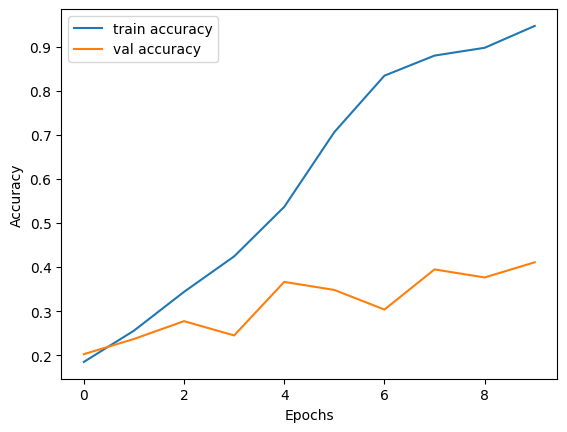

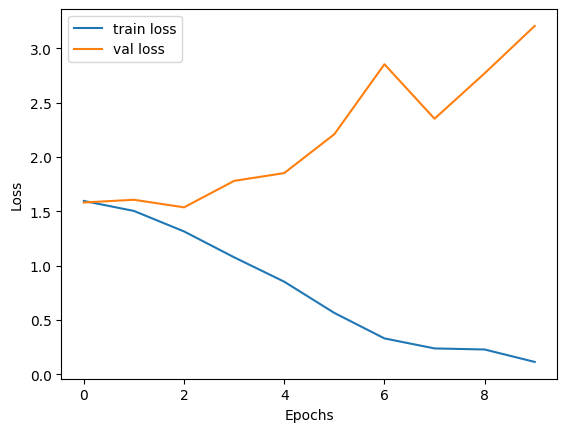

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step
Classification Report:
              precision    recall  f1-score   support

          A1       0.00      0.00      0.00        82
          A2       0.41      0.17      0.24       199
          B1       0.30      0.37      0.33       122
          B2       0.08      0.18      0.11        62
          C2       0.05      0.21      0.08        29

    accuracy                           0.19       494
   macro avg       0.17      0.18      0.15       494
weighted avg       0.25      0.19      0.20       494



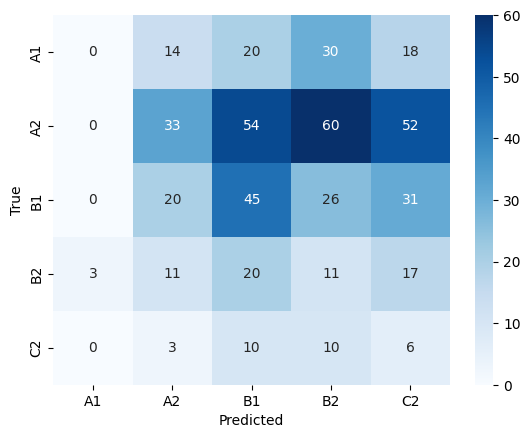

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test_pad).argmax(axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
def predict_level(text):
    # clean
    text_clean = re.sub(r'[^a-zA-Z ]', '', text).lower()
    # tokenize
    seq = tokenizer.texts_to_sequences([text_clean])
    pad = pad_sequences(seq, maxlen=200, padding='post', truncating='post')
    # predict
    pred = model.predict(pad).argmax(axis=1)
    return encoder.inverse_transform(pred)[0]

# Example usage
print(predict_level("I am learning English and I want to improve my writing skills."))
print(predict_level("The globalization of economies has profoundly affected international markets."))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
B2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
B2


In [ ]:
!pip install git+https://github.com/openai/whisper.git
!sudo apt update && sudo apt install ffmpeg


  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-6shwduin
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-6shwduin
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=d0a0722be0566ae9db7178a555426d602e8db845a9072ce53192bd6d010f402c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6e7q6umm/wheels/c3/03/25/5e0ba78bc27a3a089f137c9f1d92fdfce16d06996c071a016c
Successfully built openai-whisper
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InR

In [ ]:
uploaded_audio = files.upload()   # upload .wav, .mp3, or .m4a
audio_file = list(uploaded_audio.keys())[0]
print("Uploaded:", audio_file)


NameError: name 'files' is not defined

In [ ]:
import whisper

# Load Whisper model
model_whisper = whisper.load_model("base")

# Transcribe audio
result = model_whisper.transcribe(audio_file)
speech_text = result["text"]
print("Transcribed Speech:\n", speech_text)


In [ ]:
# Clean transcribed text
speech_text_clean = clean_text(speech_text)

# Tokenize
speech_seq = tokenizer.texts_to_sequences([speech_text_clean])
speech_pad = pad_sequences(speech_seq, maxlen=200, padding='post', truncating='post')

# Predict
prediction = model.predict(speech_pad)
predicted_class = prediction.argmax(axis=1)[0]

print("Predicted Proficiency Level:", encoder.classes_[predicted_class])
